# Data Import

In [1]:
import numpy as np
import pandas as pd

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('/kaggle/input/train.csv')
test_data = pd.read_csv('/kaggle/input/test.csv')

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

train_data.head()

Train data shape:  (891, 12)
Test data shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training data has 891 observations which is a few and 12 features (variables) including the the label we want to predict: *'Survived'*.
Based on the low number of observations we should aim for a simple model.

## Features Description

- *PassengerId*: Unique id per passenger. We won't use it as a feature for the training of our ML model.
- *Survived*: Categorical, this is the target variable for this problem.
- *Pclass*: Categorical (ordinal), describes the passenger class. It is a proxy for socio-economic status. A priori it is an important feature.
- *Name*: Text. Contains numerous information as the passenger's names and title.
- *Sex*: Categorical (nominal). A priori it is an important feature.
- *Age*: Numerical (continous). A priori it is an important feature.
- *SibSp*: Numerical (discrete). The number of siblings and spouses aboard.
- *Parch*: Numerical (discrete). The number of parents and children aboard.
- *Ticket*: Text. Ticket id.
- *Fare*: Numeric (continous). Price paid for the travel.
- *Cabin*: Text. Contains alphanumeric caracters.
- *Embarked*: Categorical (nominal). Embarkment's port.

Extra documentation available [here](https://www.kaggle.com/c/titanic/data).

## Check for missing values

In [3]:
train_data.info()
print()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null floa

- *Age*, *Cabin* and *Embarked* contains some missing values in the train dataset.
- *Age*, *Fare* and *Cabin* contains some missing values in the test dataset.

We will need to find a clever way to handle missing values.

## Features analysis

In [4]:
train_data.pivot_table(index="Pclass",values='Survived').reset_index()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
train_data.pivot_table(index="Sex",values='Survived').reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
train_data.pivot_table(index="Embarked",values='Survived').reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Features as Pclass, Sex and Embarked seems to have a significant correlation with survival and we should keep them to build our model.
However we can't find a correlation between SibSp/Parch and Survived at first glance. These features might need extra work before using them.

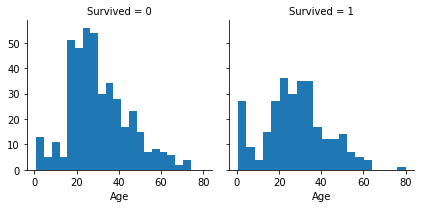

In [7]:
# Plot survival per Age bin
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

- We can observe that infants (Age <=5) have a high survival rate.
- Most passengers are in the range 20 - 40 which appears to have about 50% chance of survival.

It might be a good idea to use this feature by creating age groups.

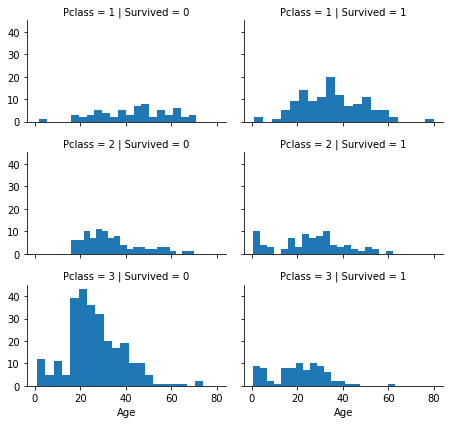

In [8]:
g = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2, aspect=1.6)
g.map(plt.hist, 'Age', bins=20)
plt.show()

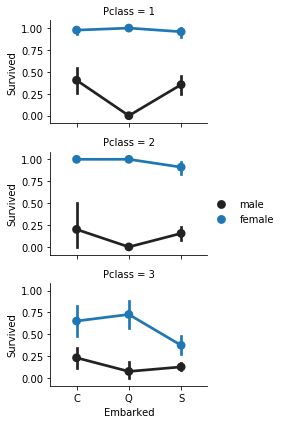

In [9]:
g = sns.FacetGrid(train_data, row='Pclass', height=2, aspect=1.6)
g.map(sns.pointplot, 'Embarked', 'Survived', 'Sex', hue_order=['male', 'female'], order=['C', 'Q', 'S'])
g.add_legend()
plt.show()

There is a relation between passenger Sex, Class and the survival rate. It might be a good idea to combine Sex and Pclass to create a feature.
Moreover we can observe that the embarkment has an impact on survival rate, and this impact is stronger on male passengers.

### Fare

In [10]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

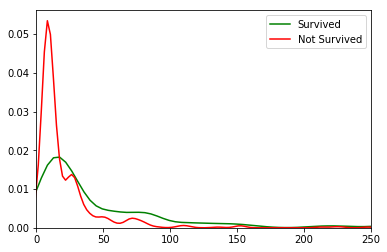

In [11]:
sns.kdeplot(train_data['Fare'][train_data.Survived == 1], color="green")
sns.kdeplot(train_data['Fare'][train_data.Survived == 0], color="red")
plt.legend(['Survived', 'Not Survived'])
plt.xlim(0, 250) # Remove the tail
plt.show()

- There are some 0's fares and we should investigate the reason why. Maybe it is for crew members?
- There is a spike in range 0-20 with a high mortality rate (about 3 times the chances of survival).
- After this range it looks like passengers are more likely to survive than to die but this relationship is also captured in Pclass so we might not need it.

Based on these observations it looks like Fare will be a useful feature for our model.

In [12]:
# Lets investigate fares=0
train_data[train_data['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


There is only one survivant amongs the 15 passengers with fare=0. Moreover we observe that they are males and have no siblings nor parents. Most of the time their cabin is not indicated and they embarked at Southampton which is the first embarkment port but also the most popular one (922 passengers over 1316).
Having fare=0 seems to be a big deal for estimating survival so we should create a feature with a column like 'has_paid_ticket'.

### Cabin Feature

In [13]:
train_data['Cabin'].value_counts(dropna=False, normalize=True)

NaN                0.771044
C23 C25 C27        0.004489
G6                 0.004489
B96 B98            0.004489
F2                 0.003367
E101               0.003367
C22 C26            0.003367
D                  0.003367
F33                0.003367
B58 B60            0.002245
B57 B59 B63 B66    0.002245
D33                0.002245
E67                0.002245
E25                0.002245
B5                 0.002245
D26                0.002245
D20                0.002245
E44                0.002245
B28                0.002245
D17                0.002245
C78                0.002245
C52                0.002245
B18                0.002245
E24                0.002245
E8                 0.002245
C123               0.002245
B51 B53 B55        0.002245
B35                0.002245
B49                0.002245
C125               0.002245
                     ...   
B39                0.001122
D11                0.001122
C54                0.001122
D6                 0.001122
B78                0

There is a lot of missing values for this feature: about 77%.

We can observe that the feature is composed of a letter and a number. The letter stands for the deck and the number for the room number.
The deck might have an influence on survival as it might have been harder to survive on lower decks.


# Data Cleaning / Feature Engineering

## Prepare dataset for training

Combine train and test to ease the process of feature engineering

In [14]:
def merge_datasets(train, test):
    columns_to_keep = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Embarked']
    columns_to_keep.extend(['Survived', 'is_train'])
    
    test['Survived'] = None
    train['is_train'] = True
    test['is_train'] = False
    
    combined_df = pd.concat([train[columns_to_keep], test[columns_to_keep]])
    combined_df['Survived'] = combined_df['Survived'].astype(float)
    
    return combined_df

combined = merge_datasets(train_data, test_data)
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Fare,Embarked,Survived,is_train
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,7.2500,S,0.0,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,71.2833,C,1.0,True
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,NaN,7.9250,S,1.0,True
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,C123,53.1000,S,1.0,True
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,NaN,8.0500,S,0.0,True


## Handle Missing values

We need to complete missing values for columns *Age*, *Cabin*, *Embarked*, *Fare*.

In [15]:
import regex as re

titles_mapping = {
        "Mr" :         "Mr",
        "Capt":        "Mr",
        "Col":         "Mr",
        "Major":       "Mr",
        "Dr":          "Mr",
        "Rev":         "Mr",
        "Jonkheer":    "Mr",
        "Don":         "Mr",
        "Sir" :        "Mr",
        "Mme":         "Mrs",
        "Mrs" :        "Mrs",
        "Countess":    "Mrs",
        "Dona":        "Mrs",
        "Lady" :       "Mrs",
        "Master" :     "Master", # Master means boy child here
        "Ms":          "Miss",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
    }

def find_title_family(name):
    p = re.compile(' ([A-Za-z]+)\.')
    title = p.search(name).group(1)
    return titles_mapping[title]

In [16]:
def fill_missing(combined):
    df = combined.copy()
    
    df['Embarked'] = df['Embarked'].fillna('S')
    
    df['Cabin'] = df['Cabin'].fillna('X')
    
    df['title'] = df['Name'].apply(find_title_family)
    
    age_group = df.groupby(['Pclass', 'title'])['Age'].mean().reset_index()
    
    def fill_age(x):
        return age_group[(age_group['Pclass'] == x['Pclass']) & 
                         (age_group['title'] == x['title'])]['Age'].values[0]
    
    df['Age'] = df.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)
    
    df['Fare'] = df['Fare'].fillna(df[df['Pclass'] == 3]['Fare'].median()) # There is 1 passenger without Fare
    
    return df
    
combined_filled = fill_missing(combined)

## Creates new features

In [17]:
# Extract deck out of Cabin column
combined_filled['deck'] = combined_filled['Cabin'].str.slice(0, 1)

# Extract Title out of Name column
combined_filled['title'] = combined_filled['Name'].apply(find_title_family)
combined_filled['surname'] = combined_filled['Name'].apply(lambda x: x.split(',')[0])

# Group Features
combined_filled['family_size'] = combined_filled['SibSp'] + combined_filled['Parch'] + 1

# People with the same fare are most likely to have bougth their tickets together
combined_filled['ticket_freq'] = combined_filled['Ticket'].map(combined_filled['Ticket'].value_counts())
combined_filled['fare_freq'] = combined_filled['Fare'].map(combined_filled['Fare'].value_counts())

combined_filled['is_large_family'] = combined_filled['family_size'] > 4

# Create has_fare feature
combined_filled['has_fare'] = combined_filled['Fare'] != 0

# Compute real fare
combined_filled['fare_per_ticket'] = combined_filled['Fare'] / combined_filled['ticket_freq']

# Create Fare bands
combined_filled['fare_band'] = pd.qcut(combined_filled['fare_per_ticket'], 5, labels=[0, 1, 2, 3, 4])

# Create Age bands
def find_age_band(age):
    if age < 14:
        return 0
    elif age <= 30:
        return 2
    elif age <= 64:
        return 1
    else: 
        return 3

combined_filled['age_band'] = combined_filled['Age'].apply(find_age_band)
combined_filled['is_minor'] = combined_filled['age_band'] == 0

combined_filled['embarked_C'] = combined_filled['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

combined_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
Pclass             1309 non-null int64
Name               1309 non-null object
Sex                1309 non-null object
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Ticket             1309 non-null object
Cabin              1309 non-null object
Fare               1309 non-null float64
Embarked           1309 non-null object
Survived           891 non-null float64
is_train           1309 non-null bool
title              1309 non-null object
deck               1309 non-null object
surname            1309 non-null object
family_size        1309 non-null int64
ticket_freq        1309 non-null int64
fare_freq          1309 non-null int64
is_large_family    1309 non-null bool
has_fare           1309 non-null bool
fare_per_ticket    1309 non-null float64
fare_band          1309 non-null category
age_band           13

In [18]:
combined_filled['ticket_formatted'] = combined_filled['Embarked'] \
    + '-' + combined_filled['Ticket'].astype(str).str.slice_replace(-2, repl='XX') \
    + '-' + combined_filled['Fare'].astype(str)

combined_filled['group_id'] = combined_filled['surname'] \
    + '-' + combined_filled['Pclass'].astype(str) \
    + '-' + combined_filled['ticket_formatted']

combined_filled['group_id'] = combined_filled.apply(
    lambda x: 'no_group' if x['title'] == 'Mr' else x['group_id'], axis=1)

combined_filled['group_freq'] = combined_filled['group_id'].map(combined_filled['group_id'].value_counts())

combined_filled['group_id'] = combined_filled.apply(
    lambda x: 'no_group' if x['group_freq'] <= 1 else x['group_id'], axis=1)

# Add nanies and relatives
group = combined_filled[combined_filled['group_id'] != 'no_group']
for i, row in combined_filled.iterrows():
    if (row['title'] != 'Mr') & (row['group_id'] == 'no_group'):
        if group[group['ticket_formatted'] == row['ticket_formatted']].shape[0] > 0:
            combined_filled.at[i, 'group_id'] = group[group['ticket_formatted'] == row['ticket_formatted']].iloc[0]['group_id']

combined_filled['group_freq'] = combined_filled['group_id'].map(combined_filled['group_id'].value_counts())

combined_filled['group_survival'] = combined_filled['group_id'].map(
    combined_filled[combined_filled['is_train']].groupby('group_id').mean()['Survived'])

survival_rates_sex_class = combined_filled[(combined_filled['is_train'] == True) & (combined_filled['group_id'] == 'no_group')].groupby(['Pclass', 'Sex']).mean()['Survived'] \
    .reset_index()

# Set group survival rate according to average survival rate for alone people of same Sex and Pclass
combined_filled['group_survival'] = combined_filled.apply(
    lambda x: combined_filled[(combined_filled['is_train'] == True) \
                & (combined_filled['group_id'] == 'no_group') \
                & (combined_filled['Pclass'] == x['Pclass']) \
                & (combined_filled['Sex'] == x['Sex'])] \
    .mean()['Survived'] if x['group_id'] == 'no_group' else x['group_survival'],
    axis=1)

def set_survival_na(x):
    if pd.isna(x['group_survival']):
        return combined_filled[combined_filled['group_freq'] == x['group_freq']].mean()['group_survival']
    else:
        return x['group_survival']

# For NaN, set to average survival rate for group of some frequency
combined_filled['group_survival'] = combined_filled.apply(set_survival_na, axis=1)

## Feature Preparation

Prepare features of the dataset before beeing able to pass them to train / test our ML model.

In [19]:
from sklearn.preprocessing import minmax_scale, StandardScaler

def dummy_encoding(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(feature, axis=1)
    return df

def prepare_features(df, features):
    """Make the feature usable by an ML algorithm"""
    df = df.copy()
    
    for col in df.columns:
        if col not in features['nominal'] + features['ordinal'] \
            + features['boolean'] + features['numeric'] + ['is_train', 'Survived']:
            df = df.drop(col, axis=1)
    
    # Transform useful features
    for feature in features['nominal']:
        df[feature] = df[feature].astype('category')
        df = dummy_encoding(df, feature)
    
    for feature in features['ordinal'] + features['boolean']:
        df[feature] = df[feature].astype('int')
    
    for feature in features['ordinal'] + features['numeric']:
        scaler = StandardScaler()
        df[[feature]] = scaler.fit_transform(df[[feature]])
        df[feature + '_scaled'] = df[feature]
        df = df.drop(feature, axis=1)
    
    return df
    
# Define type of each feature
features = {
    'nominal': ['Sex'], # sex*pclass, 'title'
    'ordinal': ['Pclass', 'fare_band'], # 'age_band'
    'boolean': ['is_minor'], # 'embarked_C', 'is_large_family', 'has_fare', 'is_minor'
    'numeric': ['group_survival'], # ['fare_per_ticket', 'Age']
}
combined_prepared = prepare_features(combined_filled, features)
combined_prepared.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Survived,is_train,is_minor,Sex_male,Pclass_scaled,fare_band_scaled,group_survival_scaled
0,0.0,True,0,1,0.841916,-0.656806,-0.779636
1,1.0,True,0,0,-1.546098,1.455624,1.657344
2,1.0,True,0,0,0.841916,0.047337,0.304792
3,1.0,True,0,0,-1.546098,1.455624,1.657344
4,0.0,True,0,1,0.841916,0.047337,-0.779636


# Train / Predict

In [20]:
X_train = combined_prepared[combined_prepared['is_train'] == 1].drop(['Survived', 'is_train'], axis=1)
y_train = combined_prepared[combined_prepared['is_train'] == 1]['Survived'].astype(int)

X_test = combined_prepared[combined_prepared['is_train'] == 0].drop(['Survived', 'is_train'], axis=1)

In [21]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [22]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

85.63

In [23]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

85.63

In [24]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

83.39

In [25]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

84.29

In [26]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

84.96

In [27]:

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc


85.52

In [28]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd


85.52

In [29]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

86.2

In [30]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100,random_state=1)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

86.2

In [31]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.20
8,Decision Tree,86.20
0,Support Vector Machines,85.63
2,Logistic Regression,85.63
6,Stochastic Gradient Decent,85.52
7,Linear SVC,85.52
5,Perceptron,84.96
4,Naive Bayes,84.29
1,KNN,83.39


In [32]:
results = pd.DataFrame({
    "PassengerId": test_data['PassengerId'],
    "Survived": Y_pred
})

In [34]:
results.to_csv('submission.csv', index=False)

results.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,0
4,896,1
